# Stephanie Schefer
## 11/1/2022
## Project 3

## 1. Import the concrete strength dataset. Use GridSearchCV to find the best epsilon (within the range 1-10) and C (within the range 1-5) values for a Support Vector Machine regression when you predict the concrete strength with a polynomial kernel of degree 2.

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
plt.rc('font', size=16)
plt.rc('axes', titlesize=16)

In [96]:
con_data = pd.read_csv("/content/drive/MyDrive/School/Applied_Machine_Learning/8_Data/concrete.csv")

con_data

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


In [97]:
x = con_data.loc[:,'cement':'age'].values
y=con_data['strength'].values

In [98]:
scale = StandardScaler()
xscaled = scale.fit_transform(x)

In [99]:
%%time
model = SVR(kernel = "poly", degree = 2)
params = [{'epsilon':np.arange(1,10.1,.25),'C':np.arange(1,5.1,.25)}] # from 1 to 10 by .25 increments, 1 to 5 by .25 increments
gs = GridSearchCV(estimator=model,cv=5,scoring='neg_mean_squared_error',param_grid=params)
gs_results = gs.fit(xscaled,y)
print(gs_results.best_params_)
print('The mean square error is: ', np.abs(gs_results.best_score_))

{'C': 1.0, 'epsilon': 10.0}
The mean square error is:  316.68027086121907
CPU times: user 1min 44s, sys: 70.7 ms, total: 1min 44s
Wall time: 1min 46s


## 2. Import the Electrical Grid dataset. Write your validation function based on stratified 10-Fold cross-validations for testing the models and record (for each classifier) the ROC curves and the AUC for detecting the class of 1 (meaning "unstable"). For each testing, fold extract the recall and precision values from the classification report and decide which model performed better based on the fold averages of ‘recall’ and ‘precision’ values.

Your project should include applications with the following classification models: K-nearest neighbors, random forests, and support vector machines with polynomial (degreee 2) and rbf kernels. In this application you do not need to optimize the hyperaparameters.

In [100]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error as mse

from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.svm import SVC

from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

In [101]:
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

In [102]:
data_electric = pd.read_csv("/content/drive/MyDrive/School/Applied_Machine_Learning/9_Data/ElectricalGridData.csv")
data_electric

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.930406,9.487627,2.376523,6.187797,3.343416,-0.658054,-1.449106,-1.236256,0.601709,0.779642,0.813512,0.608385,0.023892,unstable
9996,3.392299,1.274827,2.954947,6.894759,4.349512,-1.663661,-0.952437,-1.733414,0.502079,0.567242,0.285880,0.366120,-0.025803,stable
9997,2.364034,2.842030,8.776391,1.008906,4.299976,-1.380719,-0.943884,-1.975373,0.487838,0.986505,0.149286,0.145984,-0.031810,stable
9998,9.631511,3.994398,2.757071,7.821347,2.514755,-0.966330,-0.649915,-0.898510,0.365246,0.587558,0.889118,0.818391,0.037789,unstable


In [103]:
x = data_electric.loc[:,'tau1':'g4'].values

In [104]:
# how many different labels we need?
np.unique(data_electric['stabf'])

array(['stable', 'unstable'], dtype=object)

In [105]:
labels = LabelEncoder()
y = labels.fit_transform(data_electric['stabf'])
y # 1 is unstable

array([1, 0, 1, ..., 0, 1, 1])

## KNN

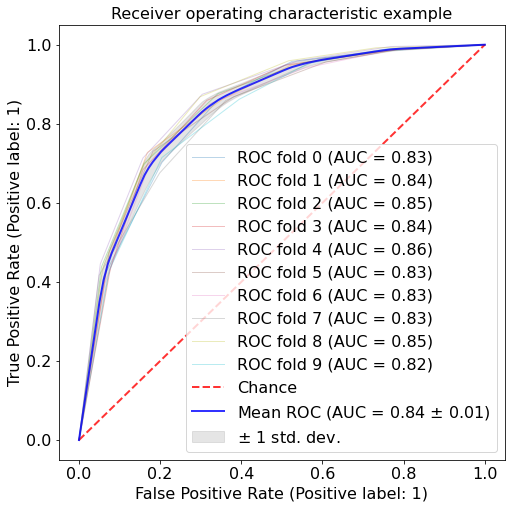

the average recall is:0.9209508881922674
the average precision is:0.8721966877812815
the average f1_score is:0.8959091161371326


In [106]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10,shuffle = True,random_state=310)
classifier = neighbors.KNeighborsClassifier()
# 5 neighbors
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

#setup empty lists for recall and precision values within each fold of kfold
recall = []
precision = []
f1_score = []

fig, ax = plt.subplots(figsize=(8,8))
for i, (train, test) in enumerate(cv.split(x, y)):
    classifier.fit(x[train], y[train])
    viz = plot_roc_curve(classifier, x[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    # recall and precision
    report = classification_report(y[train],classifier.predict(x[train]),output_dict=True) # extract report in a manner that is readable
    recall.append(report['1']['recall']) # get recall value and add to list
    precision.append(report['1']['precision']) # get precision value and add to list
    f1_score.append(report['1']['f1-score'])
     
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()


# return precision and recall
print('the average recall is:'+str(np.mean(recall)))
print('the average precision is:'+str(np.mean(precision)))
print('the average f1_score is:' + str(np.mean(f1_score)))


### Random Forest

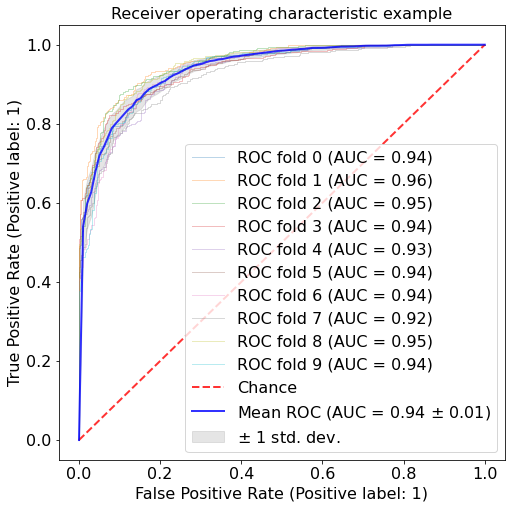

the average recall is:0.9851793800069663
the average precision is:0.8029586631943457
the average f1_score is:0.8847831196104478


In [107]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10,shuffle = True,random_state=310)
classifier = RandomForestClassifier(random_state=310, max_depth = 4, n_estimators=100)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

#setup empty lists for recall and precision values within each fold of kfold
recall = []
precision = []
f1_score = []

fig, ax = plt.subplots(figsize=(8,8))
for i, (train, test) in enumerate(cv.split(x, y)):
    classifier.fit(x[train], y[train])
    viz = plot_roc_curve(classifier, x[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    # recall and precision
    report = classification_report(y[train],classifier.predict(x[train]),output_dict=True) # extract report in a manner that is readable
    recall.append(report['1']['recall']) # get recall value and add to list
    precision.append(report['1']['precision']) # get precision value and add to list
    f1_score.append(report['1']['f1-score'])

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()


# return precision and recall
print('the average recall is:'+str(np.mean(recall)))
print('the average precision is:'+str(np.mean(precision)))
print('the average f1_score is:' + str(np.mean(f1_score)))


## Support vector machines with polynomial (degreee 2) and rbf kernels

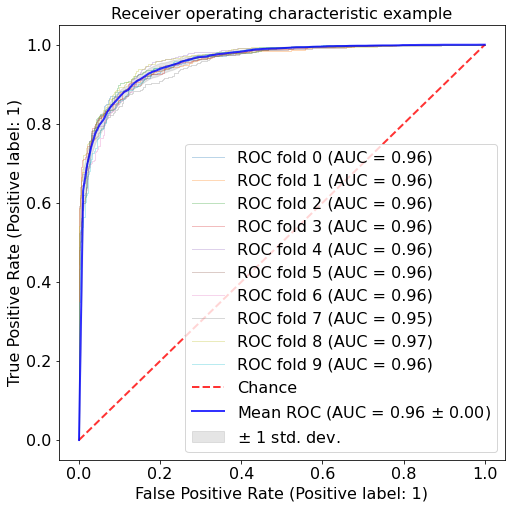

the average recall is:0.9181644026471613
the average precision is:0.9135036786212776
the average f1_score  is:0.9158273532066803


In [108]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10,shuffle = True,random_state=310)
classifier = SVC(kernel = 'poly', degree = 2)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

#setup empty lists for recall and precision values within each fold of kfold
recall = []
precision = []
f1_score = []

fig, ax = plt.subplots(figsize=(8,8))
for i, (train, test) in enumerate(cv.split(x, y)):
    classifier.fit(x[train], y[train])
    viz = plot_roc_curve(classifier, x[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    # recall and precision
    report = classification_report(y[train],classifier.predict(x[train]),output_dict=True) # extract report in a manner that is readable
    recall.append(report['1']['recall']) # get recall value and add to list
    precision.append(report['1']['precision']) # get precision value and add to list
    f1_score.append(report['1']['f1-score'])

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()


# return precision and recall
print('the average recall is:'+str(np.mean(recall)))
print('the average precision is:'+str(np.mean(precision)))
print('the average f1_score  is:' + str(np.mean(f1_score)))

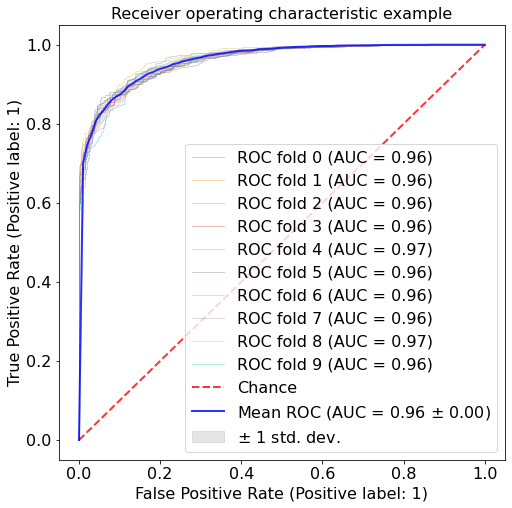

the average recall is:0.9369383490073145
the average precision is:0.897593121361359
the average f1_score is:0.9168434461246232


In [109]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10,shuffle = True,random_state=310)
classifier = SVC(kernel = 'rbf')
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

#setup empty lists for recall and precision values within each fold of kfold
recall = []
precision = []
f1_score = []

fig, ax = plt.subplots(figsize=(8,8))
for i, (train, test) in enumerate(cv.split(x, y)):
    classifier.fit(x[train], y[train])
    viz = plot_roc_curve(classifier, x[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    # recall and precision
    report = classification_report(y[train],classifier.predict(x[train]),output_dict=True) # extract report in a manner that is readable
    recall.append(report['1']['recall']) # get recall value and add to list
    precision.append(report['1']['precision']) # get precision value and add to list
    f1_score.append(report['1']['f1-score'])

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()


# return precision and recall
print('the average recall is:'+str(np.mean(recall)))
print('the average precision is:'+str(np.mean(precision)))
print('the average f1_score is:' + str(np.mean(f1_score)))

## KNN

the average recall is:0.9209508881922674

the average precision is:0.8721966877812815

the average f1_score is:0.8959091161371326


## random forest

the average recall is:0.9851793800069663

the average precision is:0.8029586631943457

the average f1_score is:0.8847831196104478


## Support Vector Machine Classification Poly

the average recall is:0.9181644026471613

the average precision is:0.9135036786212776

the average f1_score  is:0.9158273532066803

## Support Vector Machine Classification rbf

the average recall is:0.9369383490073145

the average precision is:0.897593121361359

the average f1_score is:0.9168434461246232


#The classification method with the highest average f1_score to balance the precision and recall values within each k-fold validation set is the Support Vector Machine Classification using the rbf kernel.

## 3. Re-write the simmulated annealing code (developed in-class) to accomodate a 2-D grid search optimization and apply it to determine the optimal hyperparameters for ElasticNet (such as alpha and l1_ratio) and apply it to the "housing" dataset. The variables chosen should be the same as the ones we worked on in-class.

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

plt.rc('font', size=16)
plt.rc('axes', titlesize=16)

In [111]:
# Here we have a simple implementation of Simmulated Annealing in Two Dimension
MIN_ALPHA = 0.001
MAX_ALPHA = 2

MIN_l1_RATIO = 0.001
MAX_l1_RATIO = 2

STEP_SIZE_ALPHA = 1     # Std of gaussian steps # smaller step is more cautious
STEP_SIZE_l1_Ratio = 1 
COOLING = 0.98    # T_{n+1} = T_{n}*COOLING, i.e. geometric cooling

In [112]:
def cost_function(model):
    k_fold = cross_val_score(estimator=model,X=xscaled,y=y,cv=10,scoring='neg_mean_squared_error')
    return -k_fold.mean()

def random_start():
    alpha = np.random.random()*(MAX_ALPHA-MIN_ALPHA) + MIN_ALPHA
    l1_ratio = np.random.random()*(MAX_l1_RATIO - MIN_l1_RATIO)+ MIN_l1_RATIO
    return alpha,l1_ratio

def random_neighbour(alpha,l1_ratio,T):
    delta_alpha = np.random.normal()*STEP_SIZE_ALPHA*T
    delta_l1_ratio = np.random.normal()*STEP_SIZE_l1_Ratio*T

    new_alpha = min(MAX_ALPHA, max(MIN_ALPHA, alpha+delta_alpha))
    new_l1_ratio = min(MAX_l1_RATIO, max(MIN_l1_RATIO, l1_ratio+delta_l1_ratio) )
    return new_alpha,new_l1_ratio

def acceptance_probability(cost, new_cost, temperature):
    if new_cost < cost:
        return 1
    else:
        p = np.exp(-(new_cost - cost) / temperature)
        return p
def locate_min(a):
    smallest = min(a)
    return smallest, [index for index, element in enumerate(a) if smallest == element]

def annealing(): # where the problem is # alpha0=random_start()[0],l1_ratio0 = random_start()[1]
    # Start with a random configuration
    # alpha = random_start()
    alpha0,l1_ratio0 = random_start()
    alpha = alpha0
    l1_ratio = l1_ratio0
    # All layers will have the same number of nodes (keep the example from getting too complicated)
    model = ElasticNet(alpha = alpha, l1_ratio = l1_ratio)

    # Compute the cost function (in this case, 1-accuracy)
    cost = cost_function(model)
    
    # Keep lists of results, start with the current
    states_alpha,states_l1_ratio, costs = [alpha], [l1_ratio], [cost]
    T = 1
    while T > 1e-10:
        new_alpha,new_l1_ratio = random_neighbour(alpha,l1_ratio,T)
        model = ElasticNet(alpha = new_alpha, l1_ratio = new_l1_ratio)
        new_cost = cost_function(model)
        if acceptance_probability(cost, new_cost, T) > np.random.random():
            cost = new_cost
            alpha = new_alpha
            l1_ratio = new_l1_ratio
            states_alpha.append(alpha)
            states_l1_ratio.append(l1_ratio)
            costs.append(cost)
        T = T*COOLING
    return model,states_alpha,states_l1_ratio,costs

In [113]:
data = pd.read_csv('/content/drive/MyDrive/School/Applied_Machine_Learning/7_Data/housing.csv')
data

,town,tract,longitude,latitude,crime,residential,industrial,river,nox,rooms,older,distance,highway,tax,ptratio,lstat,cmedv
0,Nahant,2011,-70.955002,42.255001,0.00632,18.0,2.31,no,0.538,6.575,65.199997,4.0900,1,296,15.300000,4.98,24.000000
1,Swampscott,2021,-70.949997,42.287498,0.02731,0.0,7.07,no,0.469,6.421,78.900002,4.9671,2,242,17.799999,9.14,21.600000
2,Swampscott,2022,-70.935997,42.283001,0.02729,0.0,7.07,no,0.469,7.185,61.099998,4.9671,2,242,17.799999,4.03,34.700001
3,Marblehead,2031,-70.928001,42.292999,0.03237,0.0,2.18,no,0.458,6.998,45.799999,6.0622,3,222,18.700001,2.94,33.400002
4,Marblehead,2032,-70.921997,42.298000,0.06905,0.0,2.18,no,0.458,7.147,54.200001,6.0622,3,222,18.700001,5.33,36.200001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,Winthrop,1801,-70.986000,42.231201,0.06263,0.0,11.93,no,0.573,6.593,69.099998,2.4786,1,273,21.000000,9.67,22.400000
502,Winthrop,1802,-70.990997,42.227501,0.04527,0.0,11.93,no,0.573,6.120,76.699997,2.2875,1,273,21.000000,9.08,20.600000
503,Winthrop,1803,-70.994797,42.226002,0.06076,0.0,11.93,no,0.573,6.976,91.000000,2.1675,1,273,21.000000,5.64,23.900000
504,Winthrop,1804,-70.987503,42.223999,0.10959,0.0,11.93,no,0.573,6.794,89.300003,2.3889,1,273,21.000000,6.48,22.000000


In [114]:
x = data.drop('river',axis=1).loc[:,'crime':'lstat'].values
y = data['cmedv'].values

In [115]:
scale = StandardScaler()
xscaled = scale.fit_transform(x)

In [116]:
model,states_alpha, states_l1_ratio, costs = annealing()

Streaming output truncated to the last 5000 lines.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py", line 926, in fit
    f"l1_ratio must be between 0 and 1; got l1_ratio={self.l1_ratio}"
ValueError: l1_ratio must be between 0 and 1; got l1_ratio=1.1176607136473022

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
----------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py", line 926, in fit
    f"l1_ratio must be between 0 and 1; got l1_ratio={self.l1_ratio}"
ValueError: l1_ratio must be between 0 and 1; got l1_ratio=1.3031397356202654

  warnings.warn(some_fits_failed_message, FitFailedWarning)

Lowest cost function value: 31.575071797546297
Best alpha value(s):
[0.15401322562536454]
Best l1_ratio value(s):
[0.001]


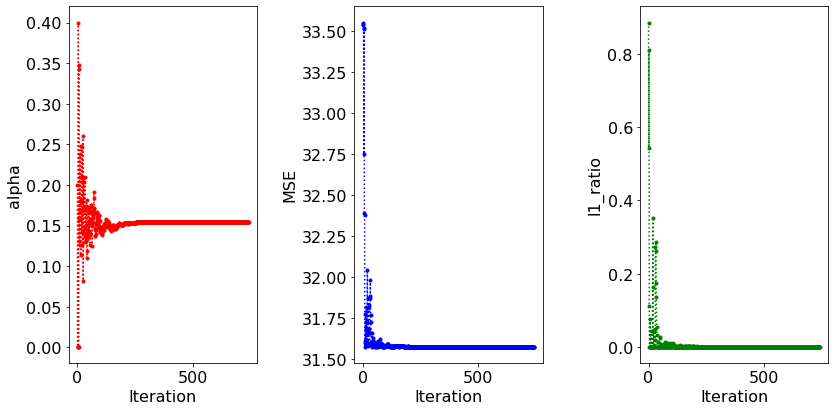

CPU times: user 19.5 s, sys: 161 ms, total: 19.7 s
Wall time: 19.6 s


In [121]:
%%time
model,states_alpha, states_l1_ratio, costs = annealing()

lowest_cost, best_states = locate_min(costs)
print('Lowest cost function value: ' + str(lowest_cost))
print('Best alpha value(s):')
print([states_alpha[idx] for idx in best_states])
print('Best l1_ratio value(s):')
print([states_l1_ratio[idx] for idx in best_states])

plt.figure(figsize=(12,6))

plt.subplot(1,3,1) # 1 row 3 col, place 1
plt.plot(states_alpha,':.r')
plt.xlabel('Iteration')
plt.ylabel('alpha')

plt.subplot(1,3,3) # 1 row 3 col, place 3
plt.plot(states_l1_ratio,':.g')
plt.xlabel('Iteration')
plt.ylabel('l1_ratio')

plt.subplot(1,3,2) # 1 row 3 col, place 2
plt.plot(costs,':.b')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.tight_layout()

plt.show()